## DataFrame benchmarks with object vs. string[pyarrow] data

In [3]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [4]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt
import os
import pyarrow as pa

In [5]:
from dask.distributed import performance_report

In [6]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(42a3ad4d, 'tcp://127.0.0.1:64549', workers=4, threads=12, memory=64.00 GiB)

In [7]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64549,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:64560,Total threads: 3
Dashboard: http://127.0.0.1:64566/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:64552,


In [13]:
# partitions in the generated dataframe
npartitions = 50

In [14]:
num_records = 500_000
unique_records = 50_000

def random_string():
    return "".join(random.choices(string.printable, k=random.randint(10, 100)))


def random_strings(n, n_unique=None):
    if n_unique is None:
        n_unique = n
    if n == n_unique:
        return (random_string() for _ in range(n_unique))
    choices = [random_string() for _ in range(n_unique)]
    return (random.choice(choices) for _ in range(n))


@delayed(pure=False)
def make_partition(dtype):
    df = pd.DataFrame({
        "name": pd.Series(random_strings(num_records, unique_records), dtype=dtype)
    })
    return df


def create_random_df(file_name, dtype):
    if not os.path.exists(file_name):
        meta = pd.DataFrame({"name": pd.Series([], dtype=dtype)})
        ddf = dd.from_delayed(
            [make_partition(object) for i in range(npartitions)],
            meta=meta
        )
        ddf.to_parquet(file_name, engine="pyarrow", overwrite=True)
    return dd.read_parquet(file_name, engine="pyarrow")
    

In [20]:
def get_ddf(persist=False, file_name="data3.parquet"):
    ddf = create_random_df(file_name, object)
    return ddf.persist() if persist else ddf

In [27]:
def get_ddf2(persist=False, file_name="data4.parquet"):
    with dask.config.set({"dataframe.convert_string": True}):
        ddf = create_random_df(file_name, "string[pyarrow]")
        return ddf.persist() if persist else ddf

## Memory usage

In [21]:
from dask.utils import format_bytes

In [22]:
client.restart();

2023-03-31 19:38:24,507 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:38:24,522 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:38:24,532 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:38:24,533 - distributed.nanny - WARNING - Restarting worker


In [23]:
ddf = get_ddf(True)

In [11]:
# ddf.size.compute()

In [24]:
ddf.dtypes

name    object
dtype: object

In [25]:
ddf.head(10)

,name
0,l5 o\Wy(q\nMk9(h;!lm-:FS*Ct(#?&CY9>cpVW.
1,iP?u\ne5-j'}hHot8y\i#gI 'Ej
2,8m;f\tDL_@Tj?~|D_Sq>6?'OSNF6S[8\zWM\rV%Vy[ `i!...
3,"wxJ-vhE*o>:\X'fC&*V`]5,q+!aa@r(2Qs3J.J1ci\n/K'..."
4,TeG\]2fImV*b='(}k/MuMscKBw'!qCd?m{fnz`lkk-TLA=...
5,zyWCZR\Dnn7Np!b]Uo9]`'\rE!|k <EAZ{4k-_CTYJy5tm...
6,"eGz])Nu\rLt 2uklbbe}k.~V\na.5{@C\na]Q[!,=~&D3:..."
7,"m7%q,%\n4HX:'Guo~9Fx""Y,|WD$#x~Loc$TvQMu-`M.Qow..."
8,x Ud*mgUOw
9,KFnHt\r}\t]{hOp\t\r?>DKJ[rfOdPnp{SBDk-AKnk#Y0v...


In [26]:
format_bytes(ddf.memory_usage(deep=True).sum().compute())

'2.79 GiB'

In [94]:
memory_usage_object = ddf.memory_usage_per_partition(deep=True).compute().apply(format_bytes)
memory_usage_object

0     57.21 MiB
1     57.30 MiB
2     57.29 MiB
3     57.26 MiB
4     57.25 MiB
5     57.14 MiB
6     57.20 MiB
7     57.29 MiB
8     57.27 MiB
9     57.24 MiB
10    57.16 MiB
11    57.23 MiB
12    57.29 MiB
13    57.20 MiB
14    57.15 MiB
15    57.15 MiB
16    57.21 MiB
17    57.21 MiB
18    57.22 MiB
19    57.29 MiB
20    57.16 MiB
21    57.24 MiB
22    57.23 MiB
23    57.17 MiB
24    57.19 MiB
25    57.22 MiB
26    57.21 MiB
27    57.32 MiB
28    57.24 MiB
29    57.22 MiB
30    57.27 MiB
31    57.16 MiB
32    57.30 MiB
33    57.18 MiB
34    57.33 MiB
35    57.28 MiB
36    57.29 MiB
37    57.15 MiB
38    57.23 MiB
39    57.09 MiB
40    57.27 MiB
41    57.23 MiB
42    57.22 MiB
43    57.23 MiB
44    57.24 MiB
45    57.23 MiB
46    57.23 MiB
47    57.22 MiB
48    57.21 MiB
49    57.21 MiB
dtype: object

In [28]:
client.restart();

2023-03-31 19:40:09,691 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:40:09,720 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:40:09,731 - distributed.nanny - WARNING - Restarting worker
2023-03-31 19:40:09,732 - distributed.nanny - WARNING - Restarting worker


In [29]:
ddf2 = get_ddf2(True)

In [30]:
ddf2.dtypes

name    string[pyarrow]
dtype: object

In [31]:
format_bytes(ddf2.memory_usage(deep=True).sum().compute())

'1.56 GiB'

In [99]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     31.95 MiB
1     32.00 MiB
2     31.90 MiB
3     31.93 MiB
4     31.92 MiB
5     31.96 MiB
6     31.94 MiB
7     31.93 MiB
8     31.94 MiB
9     31.99 MiB
10    31.95 MiB
11    31.95 MiB
12    32.01 MiB
13    31.90 MiB
14    31.90 MiB
15    31.90 MiB
16    32.07 MiB
17    31.92 MiB
18    31.91 MiB
19    32.00 MiB
20    32.00 MiB
21    31.96 MiB
22    31.75 MiB
23    32.01 MiB
24    31.85 MiB
25    32.05 MiB
26    32.02 MiB
27    32.00 MiB
28    31.95 MiB
29    31.99 MiB
30    32.00 MiB
31    32.03 MiB
32    31.88 MiB
33    31.94 MiB
34    31.92 MiB
35    31.93 MiB
36    31.98 MiB
37    31.95 MiB
38    31.94 MiB
39    31.95 MiB
40    31.94 MiB
41    32.02 MiB
42    31.91 MiB
43    32.01 MiB
44    31.94 MiB
45    31.97 MiB
46    32.01 MiB
47    31.93 MiB
48    31.91 MiB
49    32.03 MiB
dtype: object

## Running time

In [10]:
client.restart();

2023-03-31 17:43:09,551 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:43:09,560 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:43:09,561 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:43:09,562 - distributed.nanny - WARNING - Restarting worker


In [11]:
ddf = get_ddf(True)

In [12]:
wait(ddf);

In [13]:
%timeit -r 5 -n 2 ddf.name.unique().compute()

2 s ± 403 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [14]:
%timeit -r 5 -n 2 ddf.groupby("name").count().compute()

2.83 s ± 12.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [15]:
%timeit -r 5 -n 2 ddf.name.str.startswith("a").compute()

1.46 s ± 25.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [16]:
%timeit -r 5 -n 2 ddf.name.str.len().compute()

1.48 s ± 9.32 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [17]:
client.restart();

2023-03-31 17:45:46,109 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:45:46,130 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:45:46,132 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:45:46,137 - distributed.nanny - WARNING - Restarting worker


In [18]:
ddf2 = get_ddf2(True)

In [19]:
wait(ddf2);

In [20]:
%timeit -r 5 -n 2 ddf2.name.unique().compute()

768 ms ± 265 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [22]:
%timeit -r 5 -n 2 ddf2.groupby("name").count().compute()

1.23 s ± 4.8 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [23]:
%timeit -r 5 -n 2 ddf2.name.str.startswith("a").compute()

503 ms ± 16.3 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [24]:
%timeit -r 5 -n 2 ddf2.name.str.len().compute()

793 ms ± 9.33 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [36]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [37]:
report_dir = "performance/local4workers3"

In [38]:
import time

## Benchmark 1

In [49]:
client.restart();

2023-03-31 17:14:29,683 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:29,697 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:29,698 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:29,705 - distributed.nanny - WARNING - Restarting worker


In [50]:
ddf = get_ddf(True)

In [51]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.unique().count().compute()
            time.sleep(0.2)

In [52]:
client.restart();

2023-03-31 17:14:46,900 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:46,923 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:46,925 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:14:46,930 - distributed.nanny - WARNING - Restarting worker


In [53]:
ddf2 = get_ddf2(True)

In [54]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(5):
            ddf2.name.unique().count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

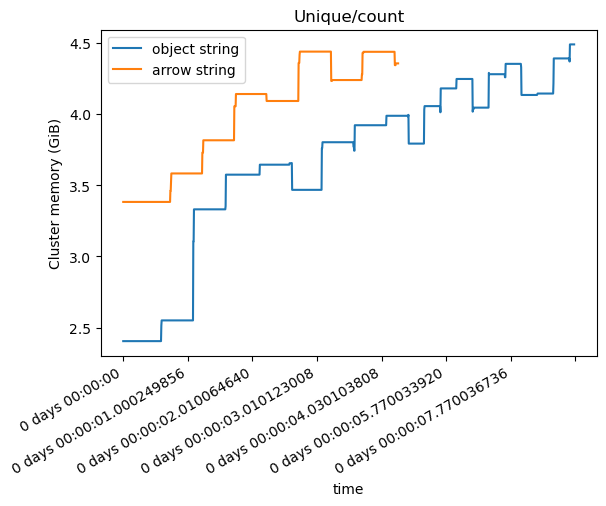

In [55]:
ms1.plot(align=True, title="Unique/count")

## Benchmark 2

In [56]:
client.restart();

2023-03-31 17:15:16,738 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:16,756 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:16,757 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:16,758 - distributed.nanny - WARNING - Restarting worker


In [57]:
ddf = get_ddf(True)

In [58]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.groupby("name").count().compute()
            time.sleep(0.2)

In [59]:
client.restart();

2023-03-31 17:15:54,790 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:54,809 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:54,810 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:15:54,811 - distributed.nanny - WARNING - Restarting worker


In [60]:
ddf2 = get_ddf2(True)

In [61]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(5):
            ddf2.groupby("name").count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

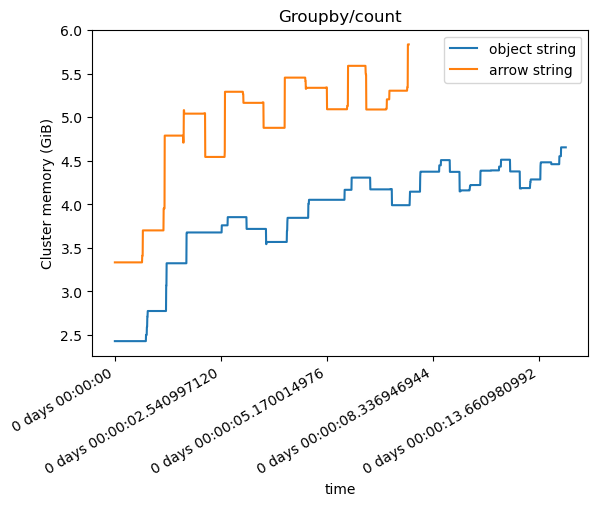

In [62]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [63]:
client.restart();

2023-03-31 17:16:25,504 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:25,525 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:25,526 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:25,527 - distributed.nanny - WARNING - Restarting worker


In [64]:
ddf = get_ddf(True)

In [65]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.str.startswith("a").compute()
            time.sleep(0.2)

In [66]:
client.restart();

2023-03-31 17:16:47,177 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:47,178 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:47,201 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:16:47,203 - distributed.nanny - WARNING - Restarting worker


In [67]:
ddf2 = get_ddf2(True)

In [68]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(5):
            get_ddf2(True).name.str.startswith("a").compute()
            time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

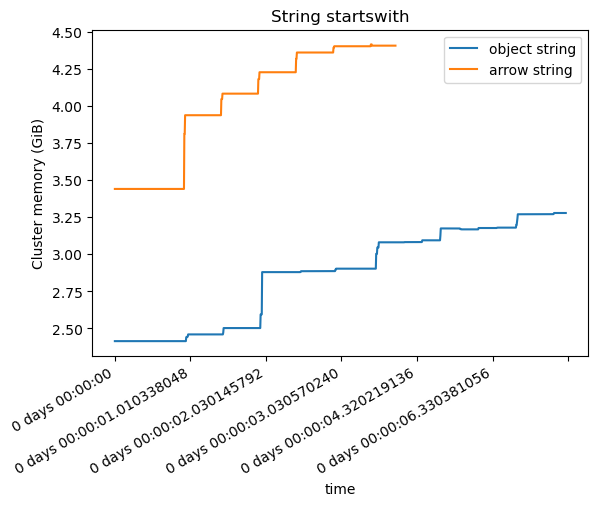

In [69]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [70]:
client.restart();

2023-03-31 17:17:14,944 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:14,974 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:14,976 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:14,977 - distributed.nanny - WARNING - Restarting worker


In [71]:
ddf = get_ddf(True)

In [72]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.str.len().compute()
            time.sleep(0.2)

In [73]:
client.restart();

2023-03-31 17:17:34,792 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:34,813 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:34,815 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:17:34,815 - distributed.nanny - WARNING - Restarting worker


In [74]:
ddf2 = get_ddf2(True)

In [75]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(5):
            ddf2.name.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

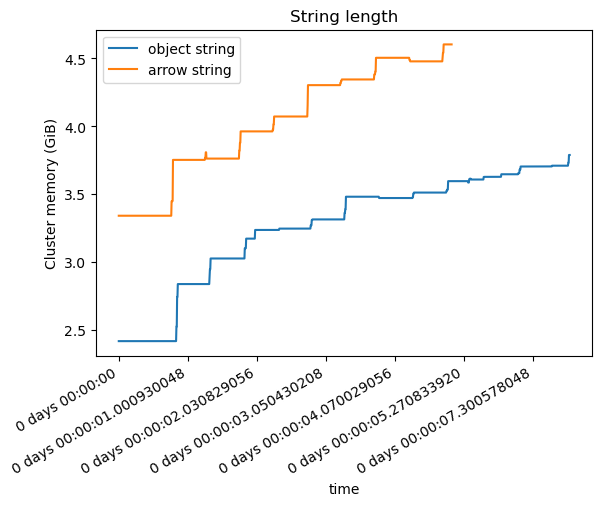

In [76]:
ms4.plot(align=True, title="String length")

In [77]:
client.close()

In [78]:
cluster.close()